In [1]:
# Import necessary libraries and modules
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_community
import numpy as np
import pandas as pd

In [2]:
# Set the matplotlib style sheet to 'custom' (my own custom style sheet (Oskar))
plt.style.use('custom')

In [3]:
# Read both the 'flights_weather_df' and 'airports_df_ext' CSV files into a DataFrame
flights_weather_df = pd.read_csv('flights_weather_df.csv')
airports_df_ext = pd.read_csv('airports_df_ext.csv')

# Create a DataFrame to store airport information
airports_df = pd.DataFrame({'iata_code': pd.concat([flights_weather_df['origin_airport'], flights_weather_df['destination_airport']]).unique()})

# Iterate through the 'airports_df' DataFrame to populate the DataFrame with longitude and latitude information from the 'Airports_df_ext' DataFrame
for index, airport in airports_df.iterrows():
    matching_row = airports_df_ext[airports_df_ext['iata_code'] == airport['iata_code']]

    coordinates = matching_row.iloc[0]['coordinates']
    longitude, latitude = map(float, coordinates.split(', '))

    airports_df.at[index, 'longitude'] = longitude
    airports_df.at[index, 'latitude'] = latitude

In [4]:
# Create a directed graph using NetworkX
G = nx.DiGraph()

# Iterate through the 'iata_code' column in the 'airports_df' DataFrame to add nodes (airports) to the graph
for iata_code in airports_df['iata_code']:
    G.add_node(iata_code)

# Iterate through the rows in the 'flights_weather_df' DataFrame to add edges with weights (flights) to the graph
for _, row in flights_weather_df.iterrows():
    if G.has_edge(row['origin_airport'], row['destination_airport']):
        G[row['origin_airport']][row['destination_airport']]['weight'] += 1
    else:
        G.add_edge(row['origin_airport'], row['destination_airport'], weight=1)

In [5]:
# Display the number of nodes (airports) in the graph
G.number_of_nodes()

363

In [6]:
# Display the number of edges (flight paths) in the graph
G.number_of_edges()

6455

In [7]:
# Display the sum of edge weights (total number of flights) in the graph
G.size(weight='weight')

5492843.0

In [8]:
# Create dictionaries to store degree, weighted degree, and betweenness centrality for each airport node
degree_dict = dict(G.degree())
weighted_degree_dict = dict(G.degree(weight='weight'))
betweenness_centrality_dict = nx.betweenness_centrality(G)

# Iterate through the 'airports_df' DataFrame to populate the DataFrame with degree, weighted degree, 
# and betweenness centrality information from the dictionaries
for index, airport in airports_df.iterrows():
    airports_df.at[index, 'degree'] = degree_dict[airport['iata_code']]
    airports_df.at[index, 'weighted_degree'] = weighted_degree_dict[airport['iata_code']]
    airports_df.at[index, 'betweenness_centrality'] = betweenness_centrality_dict[airport['iata_code']]

# Calculate and add rankings for the 'degree', 'weighted degree', and 'betweenness_centrality' columns to the 'airports_df' DataFrame
airports_df['degree_ranking'] = airports_df['degree'].rank(ascending=False, method='min')
airports_df['weighted_degree_ranking'] = airports_df['weighted_degree'].rank(ascending=False, method='min')
airports_df['betweenness_centrality_ranking'] = airports_df['betweenness_centrality'].rank(ascending=False, method='min')

# Convert the specified integer columns to integer format
int_columns = ['degree', 'weighted_degree', 'degree_ranking', 'weighted_degree_ranking', 'betweenness_centrality_ranking']
airports_df[int_columns] = airports_df[int_columns].astype(int)

# Display the resulting DataFrame
airports_df

,iata_code,longitude,latitude,degree,weighted_degree,betweenness_centrality,degree_ranking,weighted_degree_ranking,betweenness_centrality_ranking
0,SEA,-122.308998,47.449001,184,268202,0.058075,14,7,8
1,LAX,-118.407997,33.942501,221,337086,0.032984,10,6,13
2,PDX,-122.598000,45.588699,118,120186,0.004231,32,26,34
3,SFO,-122.375000,37.618999,179,239914,0.017330,17,10,17
4,ORD,-87.904800,41.978600,369,553590,0.149736,1,1,3
...,...,...,...,...,...,...,...,...,...
358,PSM,-70.823303,43.077900,10,456,0.000022,187,351,167
359,PPG,-170.710007,-14.331000,2,168,0.000000,295,356,212
360,ADK,-176.645996,51.877998,2,140,0.000000,295,360,212
361,STC,-94.059898,45.546600,4,100,0.000009,247,363,184


In [9]:
# Calculate and display the correlation matrix for degree rankings versus weighted_degree_rankings versus betweenness centrality rankings
airports_df[['degree_ranking', 'weighted_degree_ranking', 'betweenness_centrality_ranking']].corr()

,degree_ranking,weighted_degree_ranking,betweenness_centrality_ranking
degree_ranking,1.000000,0.910301,0.836761
weighted_degree_ranking,0.910301,1.000000,0.740586
betweenness_centrality_ranking,0.836761,0.740586,1.000000


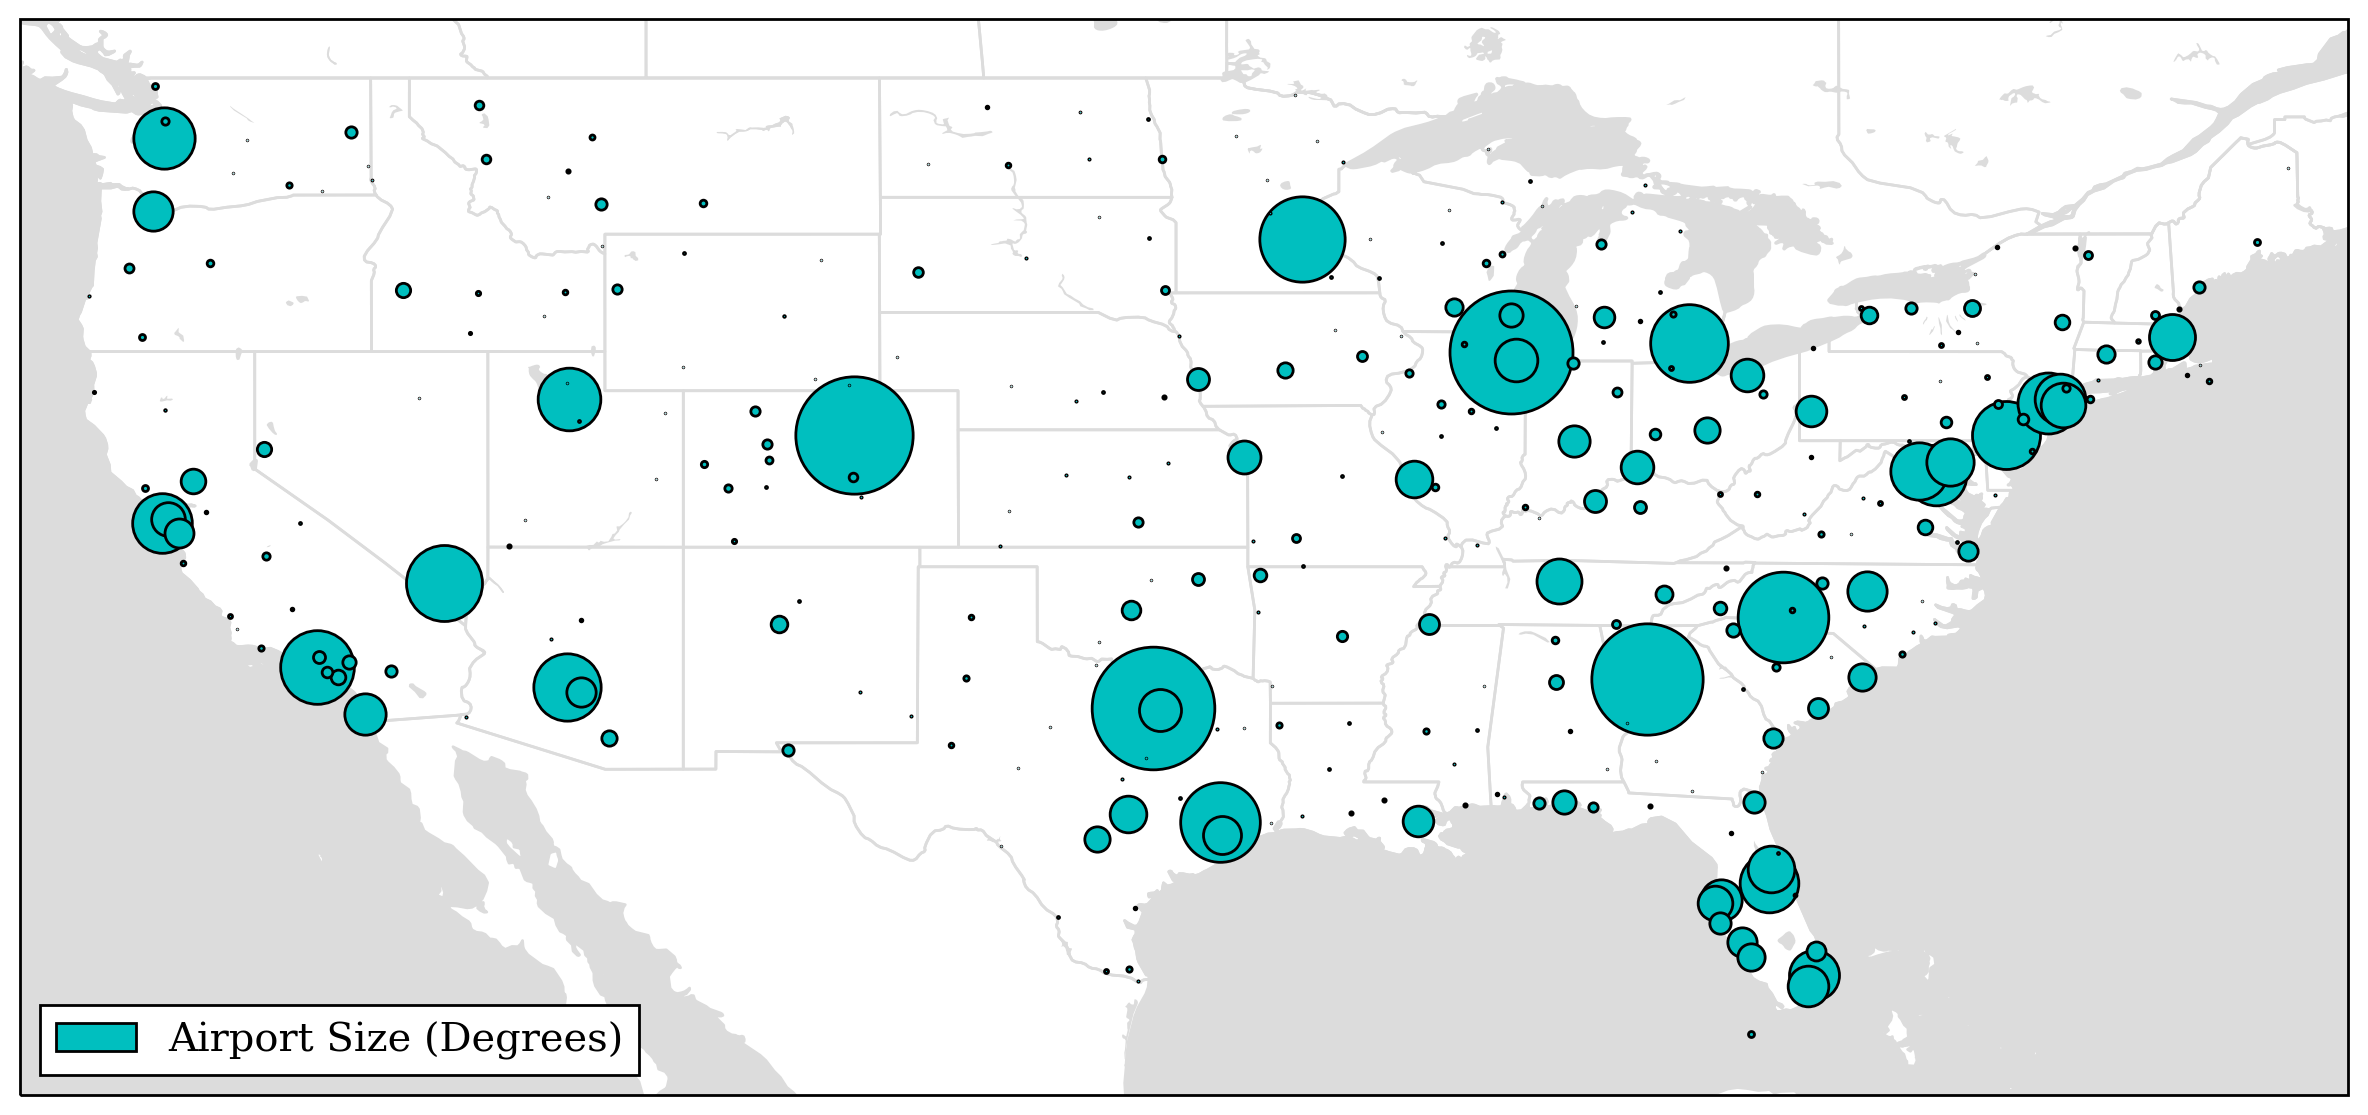

In [10]:
# Create a Matplotlib plot
plt.figure(figsize=(12, 6), dpi=200)
plt.axes(projection=ccrs.PlateCarree())
plt.xlim([-126, -66.5])
plt.ylim([23, 50.5])

# Add map features to the plot
plt.gca().add_feature(cfeature.LAND, facecolor='w')
plt.gca().add_feature(cfeature.OCEAN, facecolor='gainsboro')
plt.gca().add_feature(cfeature.LAKES, facecolor='gainsboro')
plt.gca().add_feature(cfeature.STATES, edgecolor='gainsboro')
plt.gca().add_feature(cfeature.BORDERS, edgecolor='gainsboro')
plt.gca().add_feature(cfeature.COASTLINE, edgecolor='gainsboro')

# Iterate through the 'airports_df' DataFrame and add airport markers to the plot
for _, airport in airports_df.sort_values(by='degree', ascending=False).iterrows():
    longitude = airport['longitude']
    latitude = airport['latitude']
    degree = G.degree(airport['iata_code'])
    plt.plot(longitude, latitude, marker='o', color='c', markersize=degree * 0.12, markeredgewidth=1)

# Add a legend to the plot
legend_handles = [mpatches.Circle((0, 0), 5, facecolor='c', edgecolor='black', linewidth=1, label='Airport Size (Degrees)')]
plt.legend(handles=legend_handles, loc='lower left')

# Display the resulting plot
plt.tight_layout()
plt.show()

In [11]:
# Calculate and display the average clustering coefficient of the graph
nx.average_clustering(G)  # 0.57 indicates a moderate tendency to form local clusters

0.5699501647702394

In [12]:
# Calculate and display the density of the graph
nx.density(G)  # 0.049 indicates a relatively sparse graph, as is typical for transportation networks

0.04912256670167268

In [13]:
# Find communities in the graph using greedy modularity-based community detection
communities = nx.community.greedy_modularity_communities(G, weight='weight', best_n=4)

In [14]:
# Display the number of nodes in each community
[len(community) for community in communities]

[152, 126, 58, 27]

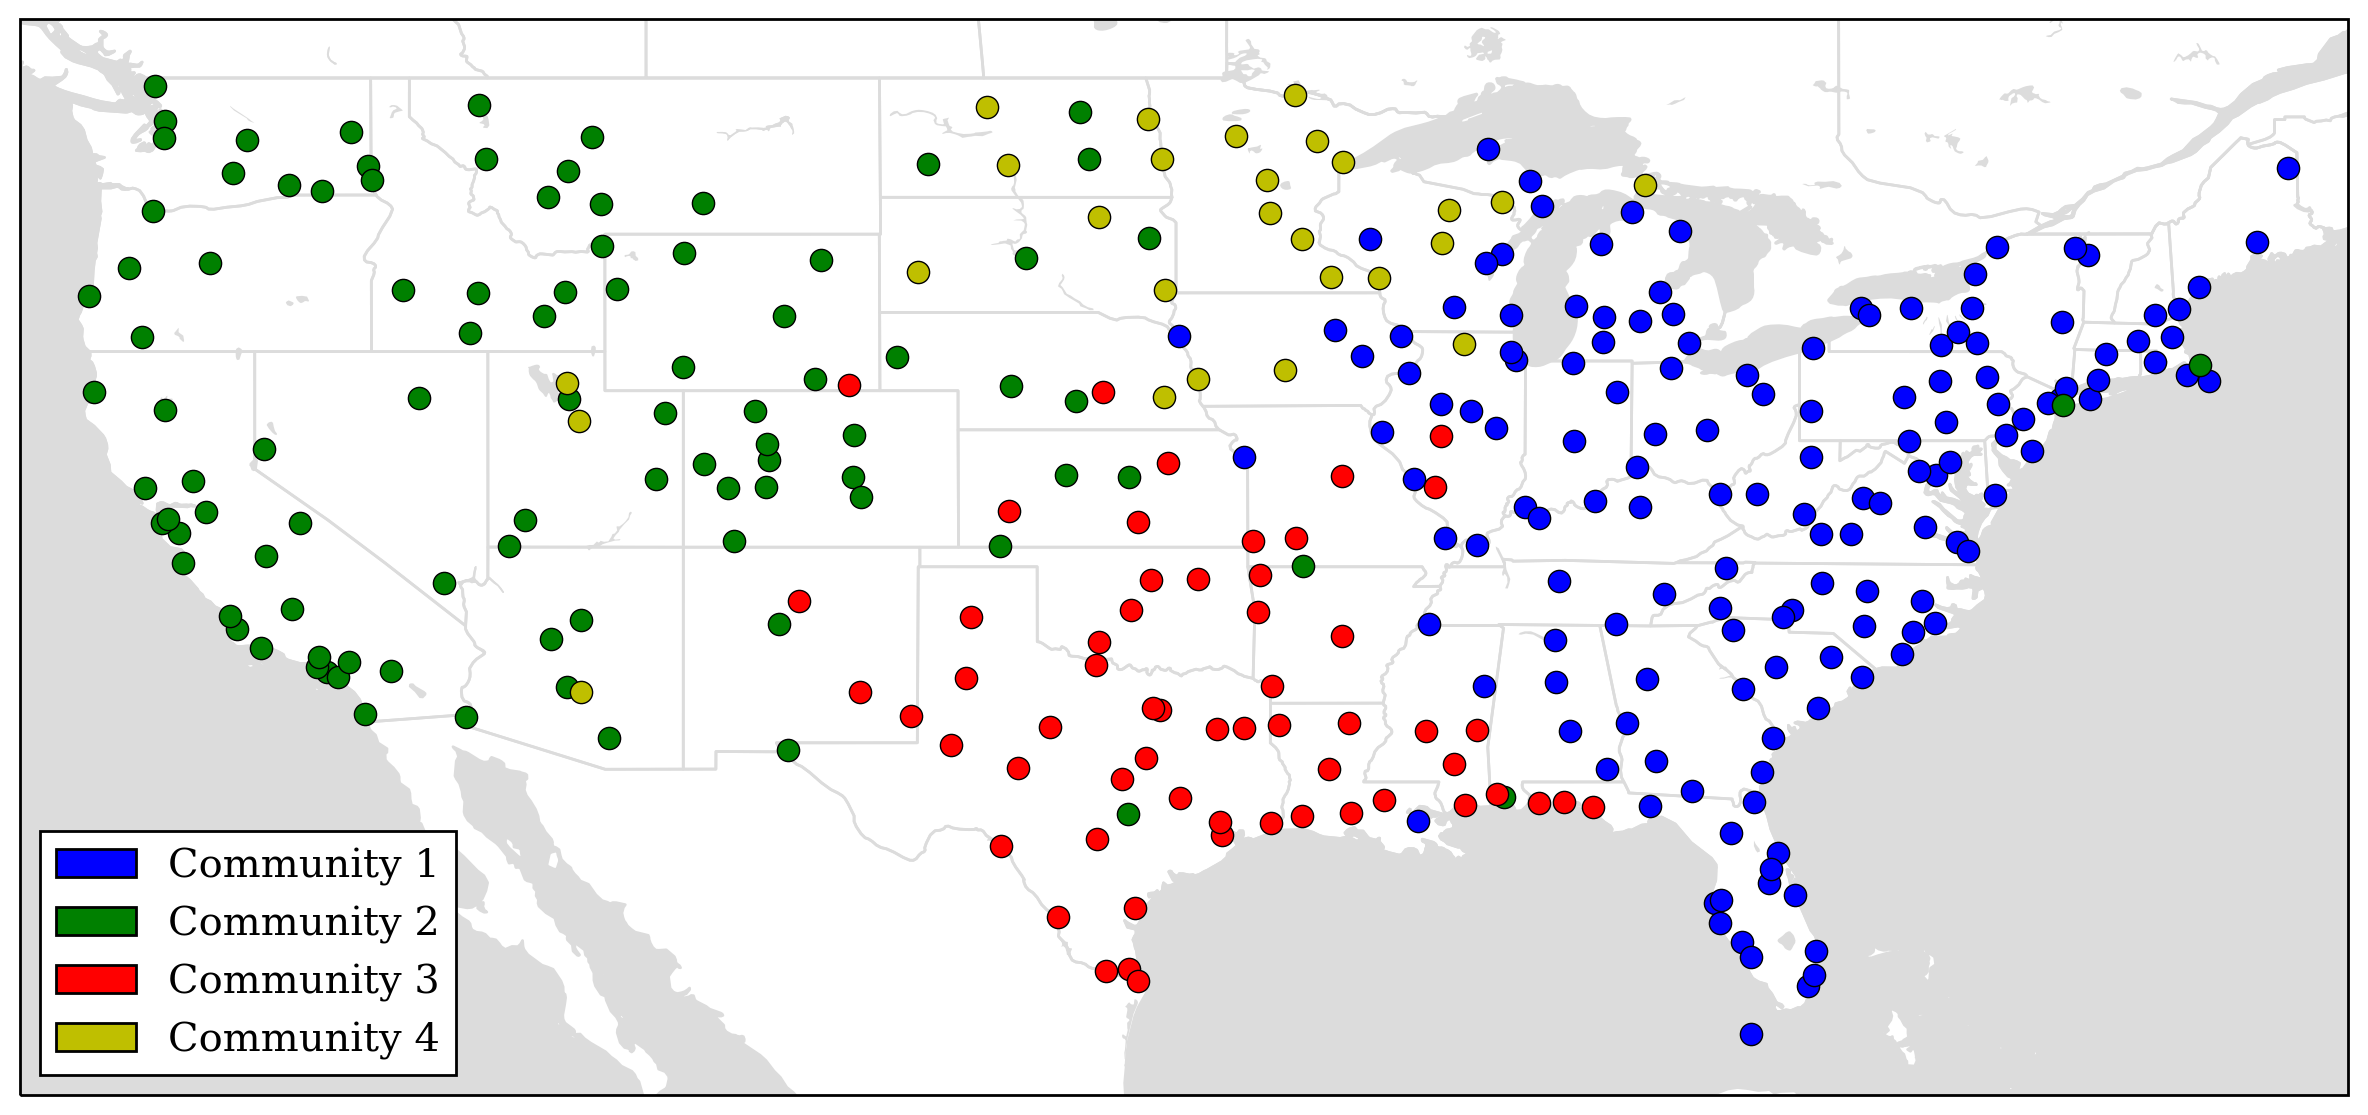

In [15]:
# Create a Matplotlib figure
plt.figure(figsize=(12, 6), dpi=200)
plt.axes(projection=ccrs.PlateCarree())
plt.xlim([-126, -66.5])
plt.ylim([23, 50.5])

# Add map features to the plot
plt.gca().add_feature(cfeature.LAND, facecolor='w')
plt.gca().add_feature(cfeature.OCEAN, facecolor='gainsboro')
plt.gca().add_feature(cfeature.LAKES, facecolor='gainsboro')
plt.gca().add_feature(cfeature.STATES, edgecolor='gainsboro')
plt.gca().add_feature(cfeature.BORDERS, edgecolor='gainsboro')
plt.gca().add_feature(cfeature.COASTLINE, edgecolor='gainsboro')

# Iterate through the communities and add airport markers to the plot
colors = ['b', 'g', 'r', 'y']

for index, community in enumerate(communities):
    for airport in community:
        matching_row = airports_df.set_index('iata_code').loc[airport]
        longitude, latitude = matching_row['longitude'], matching_row['latitude']
        plt.plot(longitude, latitude, marker='o', color=colors[index], markersize=8, alpha=1)

# Add a legend to the plot
legend_handles = [mpatches.Circle((0, 0), 1, facecolor=colors[i], label=f'Community {i+1}', edgecolor='black', linewidth=1) for i in range(len(communities))]
plt.legend(handles=legend_handles, loc='lower left')

# Display the resulting plot
plt.tight_layout()
plt.show()

In [16]:
# Calculate and display the modularity of the graph with respect to the detected communities
nx_community.modularity(G, communities, weight='weight')

0.27340000223516087

In [17]:
# Calculate and add the average departure and arrival delays for each airport to the 'airports_df' DataFrame
avg_departure_delays = flights_weather_df.groupby('origin_airport')['departure_delay'].mean().reset_index()
avg_arrival_delays = flights_weather_df.groupby('destination_airport')['arrival_delay'].mean().reset_index()

airports_df = airports_df.merge(avg_departure_delays, left_on='iata_code', right_on='origin_airport', how='right').drop(columns='origin_airport')
airports_df = airports_df.merge(avg_arrival_delays, left_on='iata_code', right_on='destination_airport', how='right').drop(columns='destination_airport')

airports_df = airports_df.rename(columns={'departure_delay': 'avg_departure_delay', 'arrival_delay': 'avg_arrival_delay'})

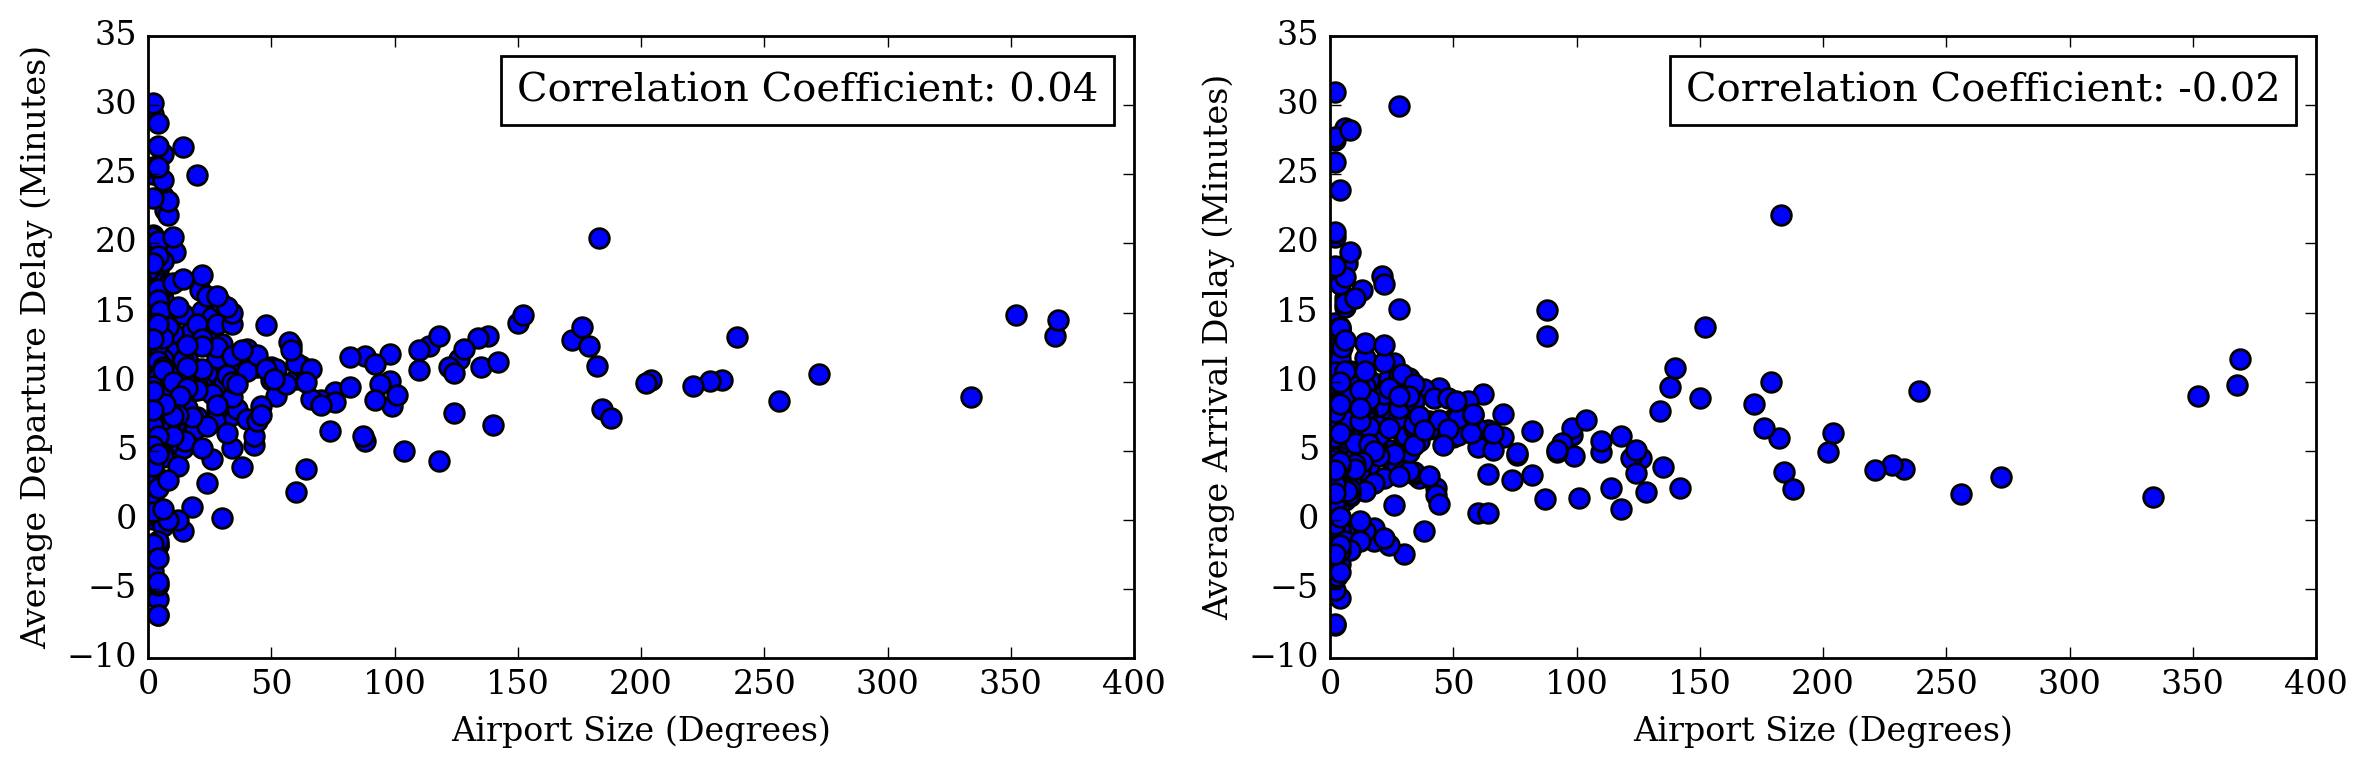

In [18]:
# Calculate and store the correlation between degrees versus average departure and arrival delays, respectively
departure_correlation = airports_df['degree'].corr(airports_df['avg_departure_delay'])
arrival_correlation = airports_df['degree'].corr(airports_df['avg_arrival_delay'])

# Create a Matplotlib plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=200)

# Add the scatter plot for degrees versus average departure delays to the plot
ax1.scatter(airports_df['degree'], airports_df['avg_departure_delay'], s=50)
ax1.set_xlabel('Airport Size (Degrees)')
ax1.set_ylabel('Average Departure Delay (Minutes)')
departure_legend_handle = [Line2D([0], [0], color='w', label=f'Correlation Coefficient: {round(departure_correlation, 2)}', markersize=0)]
ax1.legend(handles=departure_legend_handle, handlelength=0, handletextpad=0, loc='upper right')
ax1.set_xlim(0, ax1.get_xlim()[1])

# Add the scatter plot for degrees versus average arrival delays to the plot
ax2.scatter(airports_df['degree'], airports_df['avg_arrival_delay'], s=50)
ax2.set_xlabel('Airport Size (Degrees)')
ax2.set_ylabel('Average Arrival Delay (Minutes)')
arrival_legend_handle = [Line2D([0], [0], color='w', label=f'Correlation Coefficient: {round(arrival_correlation, 2)}', markersize=0)]
ax2.legend(handles=arrival_legend_handle, handlelength=0, handletextpad=0, loc='upper right')
ax2.set_xlim(0, ax2.get_xlim()[1])

# Display the resulting plot
plt.tight_layout()
plt.show()

/var/folders/cw/pqgxbbt56vlc2fjkxx_jn6p00000gn/T/ipykernel_22933/3513056249.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(monthly_avg_delays['scheduled_departure_dt'].dt.strftime('%b'))


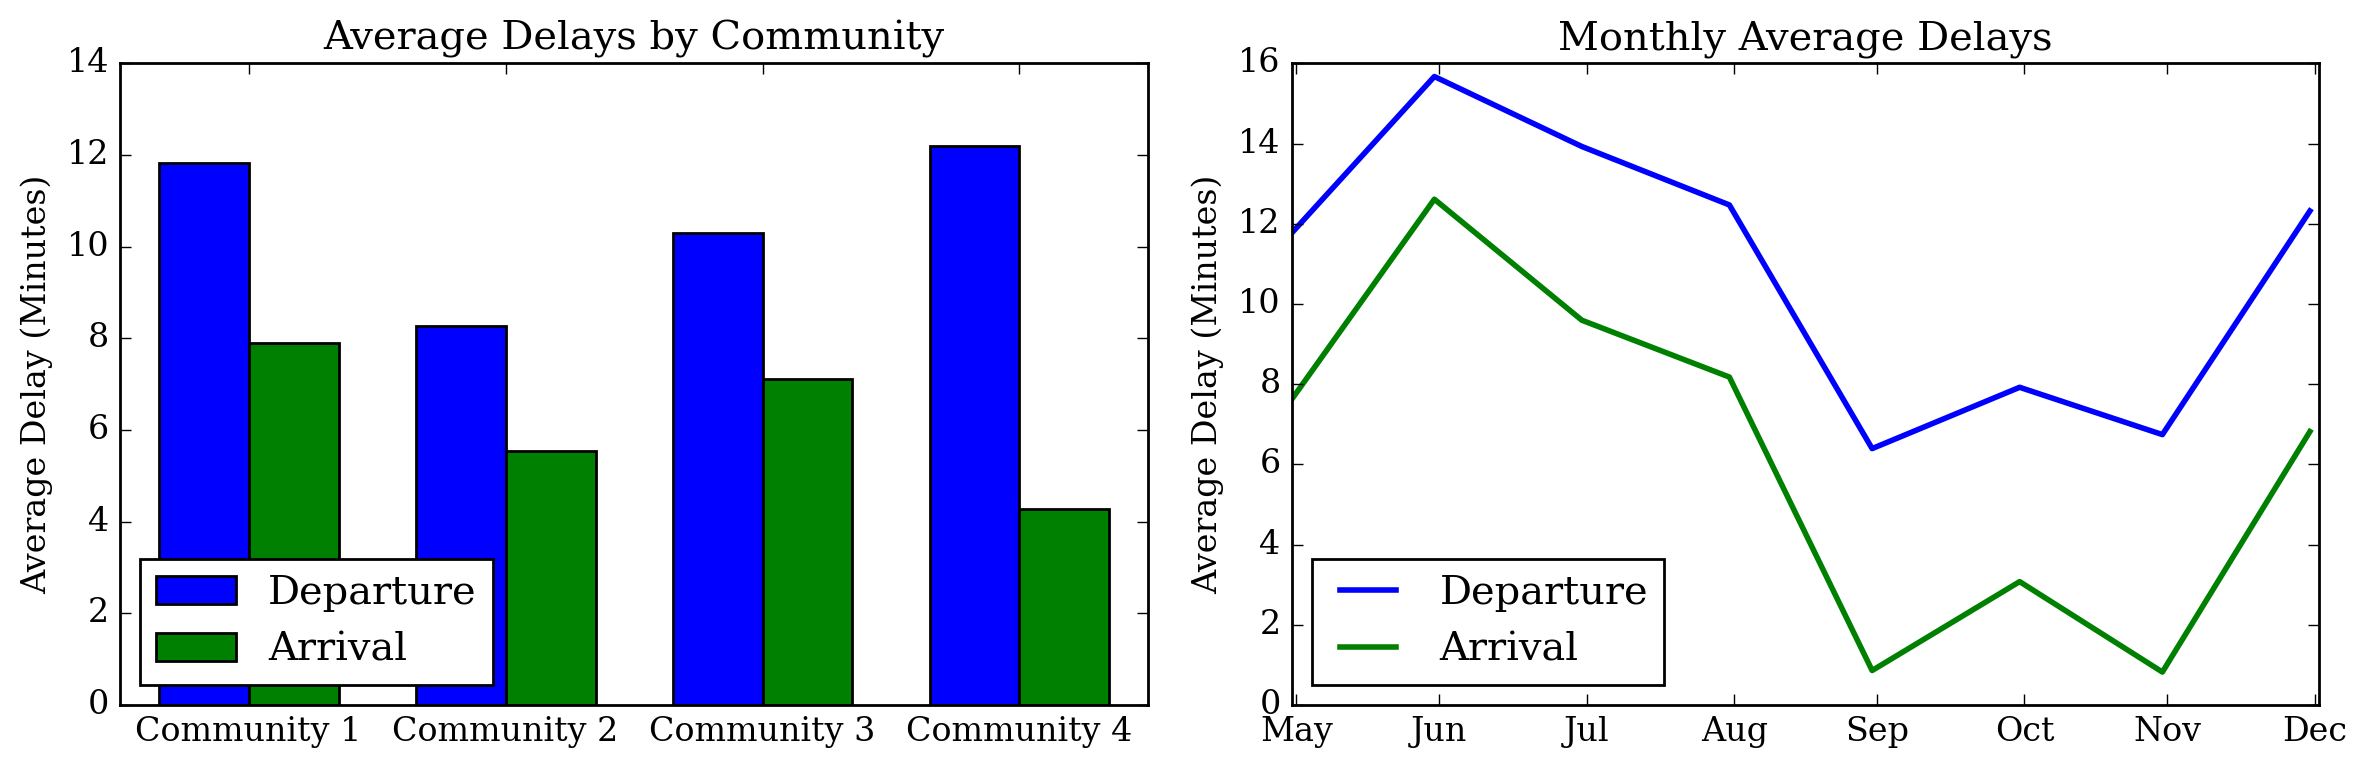

In [19]:
# Add the community label for each airport to the 'airports_df' DataFrame
iata_to_community = {iata: index+1 for index, community in enumerate(communities) for iata in community}
airports_df['community'] = airports_df['iata_code'].map(iata_to_community)

# Calculate and store the average departure and arrival delays by community
community_avg_delays = airports_df.groupby('community').agg({
    'avg_departure_delay': 'mean',
    'avg_arrival_delay': 'mean'
}).reset_index()

# Create and set up a Matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=200)

# Add the bar chart for average departure and arrival delays by community to the plot
bar_positions = np.arange(len(community_avg_delays))
bar_width = 0.35

ax1.bar(bar_positions - bar_width/2, community_avg_delays['avg_departure_delay'], bar_width, label='Departure')
ax1.bar(bar_positions + bar_width/2, community_avg_delays['avg_arrival_delay'], bar_width, label='Arrival')
ax1.set_ylabel('Average Delay (Minutes)')
ax1.set_xticks(bar_positions)
ax1.set_xticklabels([f"Community {i}" for i in community_avg_delays['community']])
ax1.legend(loc='lower left')
ax1.set_title('Average Delays by Community')

# Convert the 'scheduled_departure_dt' column to datetime format
flights_weather_df['scheduled_departure_dt'] = pd.to_datetime(flights_weather_df['scheduled_departure_dt'])

# Calculate and store the monthly average departure and arrival delays
monthly_avg_delays = flights_weather_df.groupby(pd.Grouper(key='scheduled_departure_dt', freq='M')).agg({
    'departure_delay': 'mean',
    'arrival_delay': 'mean'
}).reset_index()

# Add the line chart for monthly average departure and arrival delays to the plot
ax2.plot(monthly_avg_delays['scheduled_departure_dt'], monthly_avg_delays['departure_delay'], label='Departure', linewidth=2)
ax2.plot(monthly_avg_delays['scheduled_departure_dt'], monthly_avg_delays['arrival_delay'], label='Arrival', linewidth=2)
ax2.set_ylabel('Average Delay (Minutes)')
ax2.set_xticklabels(monthly_avg_delays['scheduled_departure_dt'].dt.strftime('%b'))
ax2.legend(loc='lower left')
ax2.set_title('Monthly Average Delays')
ax2.set_xlim(ax2.get_xlim()[0], ax2.get_xlim()[1]+2)

# Display the resulting plot
fig.tight_layout()
plt.show()